# Solar in situ comparison

In [1]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import glob
import calendar
import seaborn as sns
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *
from scipy import stats
import itertools

In [2]:
#switch to select 3x3 grid box from reanalyses when comparing to in situ point data
grid_box_select_switch = True

In [3]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [4]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36467/status,
Dashboard: /proxy/36467/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36433,Workers: 10
Dashboard: /proxy/36467/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:43457,Total threads: 1
Dashboard: /proxy/40741/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:44863,


## Domain and data availability plots

### Solar data availability

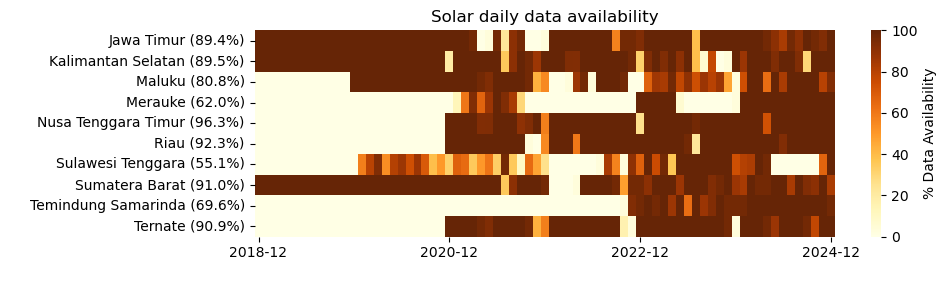

<Figure size 640x480 with 0 Axes>

In [5]:
solar_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/solar/station_metadata.csv').drop(columns=['No']).dropna()

files = ['/g/data/qz03/wp3/data/obs/solar/' + f for f in os.listdir('/g/data/qz03/wp3/data/obs/solar') if 'station_metadata' not in f and '.ipynb' not in f]
dfs = {f.split('/')[-1].replace('.csv',''): pd.read_csv(f) for f in files}

months_list = []
for df in dfs.values():
    df['Date'] = pd.to_datetime(df['Date'])
    months_list.append(df['Date'].dt.tz_convert(None).dt.to_period('M').drop_duplicates())

all_months = pd.Index(pd.concat(months_list).drop_duplicates()).sort_values()

availability = pd.DataFrame(index=dfs.keys(), columns=all_months.astype(str))
for station, df in dfs.items():
    df['year_month'] = df['Date'].dt.tz_convert(None).dt.to_period('M')
    total_per_month = df.groupby('year_month').size()
    avail_per_month = df.groupby('year_month')['GHI_sum'].apply(lambda x: (x.notna() & (x != 0)).sum()) 
    pct = (avail_per_month / total_per_month).reindex(all_months, fill_value=0) * 100
    availability.loc[station] = pct.values
    
availability.index = availability.index.str[:5]
new_index = []
for station, df in dfs.items():
    total = len(df)
    available = (df['GHI_sum'].notna() & (df['GHI_sum'] != 0)).sum()
    percent = (available / total) * 100 if total > 0 else 0
    label = f"{station.split('_')[1]} ({percent:.1f}%)"
    new_index.append(label)

availability.index = new_index
availability.sort_index(inplace=True)
plt.figure(figsize=(10, len(dfs)*0.05 + 2.5))
sns.heatmap(availability.astype(float), cmap='YlOrBr', cbar_kws={'label': '% Data Availability'}, xticklabels=24)
plt.title("Solar daily data availability")
plt.ylabel(' ')
plt.xlabel(' ')
plt.tight_layout()
plt.show()
plt.clf()

In [6]:
solar_station_latlon_df.sort_values(by='Station Name', inplace=True)
solar_station_latlon_df['status'] = [1, 1, 1, 2, 1, 1, 2, 1, 2, 1]
solar_station_latlon_df

,Station Name,Lat,Lon,status
2,Jawa Timur,-7.901390,112.596670,1
3,Kalimantan Selatan,-3.462250,114.840840,1
8,Maluku,-3.338810,128.368450,1
9,Merauke,-8.387090,140.516500,2
5,Nusa Tenggara Timur,-10.139000,123.666900,1
1,Riau,0.411970,101.216930,1
6,Sulawesi Tenggara,-4.056220,122.449160,2
0,Sumatera Barat,-0.550000,100.370000,1
4,Temindung Samarinda,-0.374146,117.253808,2
7,Ternate,0.825940,127.381300,1


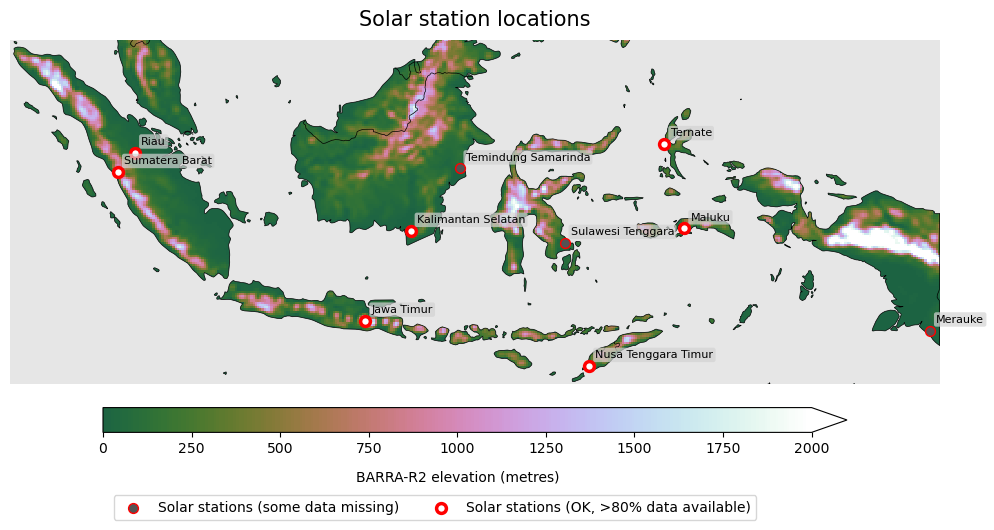

<Figure size 640x480 with 0 Axes>

In [7]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

barra_topo = xr.open_dataset(f'{barraR2_dir}fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').sel(lat=slice(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']), lon=slice(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max']))
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = barra_topo.orog.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmax=2000, cmap=mcolors.LinearSegmentedColormap.from_list('trunc', plt.get_cmap('cubehelix')(np.linspace(5/17, 1, 256))), add_colorbar=False)
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', extend='max', shrink=0.8, aspect=30, pad=0.05)
cbar.set_label('BARRA-R2 elevation (metres)', labelpad=10)
ax.set_title("Solar station locations", size=15, pad=10)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#e6e6e6', alpha=1)
ax.set_frame_on(False)

ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'Lon'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='red', s=50, linewidth=1, label='Solar stations (some data missing)', zorder=20)
ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'Lon'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='red', s=50, linewidth=2.5, label='Solar stations (OK, >80% data available)', zorder=20)

for _, row in solar_station_latlon_df.iterrows():
    ax.text(row['Lon']+0.3, row['Lat']+0.3, str(row['Station Name']), transform=ccrs.PlateCarree(),
            fontsize=8, ha='left', va='bottom', zorder=25, color='black', bbox=dict(facecolor='lightgrey', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))


ax.legend(ncol=2, bbox_to_anchor=(0.81, -0.3))
plt.show()
plt.clf()

In [8]:
solar_station_df = pd.concat([pd.read_csv(f, parse_dates=['Date']).assign(station_id=os.path.basename(f).split('_')[1]) for f in glob.glob('/g/data/qz03/wp3/data/obs/solar/*daily.csv')], ignore_index=True)

In [13]:
%%time
barra_rsds_dly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/day/rsds/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
era5_rsds_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/ssrd/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})

CPU times: user 1.36 s, sys: 273 ms, total: 1.63 s
Wall time: 3.08 s


In [39]:
%%time
era5_daily_resampled = ((barra_rsds_dly.rsds*0.024).sortby('time')).chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()
barra_daily_resampled = (era5_rsds_hly.ssrd.sortby("time")/(3.6e6)).resample(time='D').sum().chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()

CPU times: user 30.2 s, sys: 9.84 s, total: 40.1 s
Wall time: 51.7 s


In [40]:
def grid_box_select(solar_reanalysis, model_res):
    solar = []
    for lat_offset, lon_offset in itertools.product([-model_res, 0, model_res], [-model_res, 0, model_res]):
        solar.append(solar_reanalysis.sel(lat=lat+lon_offset, lon=lon, method='nearest').compute().sortby("time"))
    solar_pt = xr.concat(solar, dim='z').mean('z').compute().sortby("time")
    return solar_pt

def point_select(solar_reanalysis):
    solar_pt = solar_reanalysis.sel(lat=lat, lon=lon, method='nearest').compute().sortby("time")
    return solar_pt

In [41]:
agg_df = []
for station_id in solar_station_latlon_df['Station Name']:
    print(station_id)
    lat, lon = solar_station_latlon_df.loc[solar_station_latlon_df['Station Name'] == station_id, ['Lat', 'Lon']].values[0]
    station_df = solar_station_df[solar_station_df['station_id'] == (station_id)].copy()
    station_df['Date'] = pd.to_datetime(station_df['Date']).dt.floor('D').dt.tz_localize(None).dt.floor('D')
    
    # BARRA extract
    barra = grid_box_select(barra_daily_resampled, 0.1)*1000/24 if grid_box_select_switch == True else point_select(barra_daily_resampled)*1000/24

    # ERA5 extract
    era5 = grid_box_select(era5_daily_resampled, 0.25)*1000/24 if grid_box_select_switch == True else point_select(era5_daily_resampled)*1000/24

    # Convert to pandas Series and reset index
    barra_series = barra.to_series().reset_index(name='BARRA_GHI').sort_values('time')
    era5_series = era5.to_series().reset_index(name='ERA5_GHI').sort_values('time')

    # Merge station data with reanalysis data on time
    df = pd.merge_asof(
    pd.merge_asof(station_df.sort_values('Date'), barra_series, left_on='Date', right_on='time', direction='nearest').drop(columns='time'),
    era5_series, left_on='Date', right_on='time', direction='nearest').drop(columns='time')
    
    agg_df.append(df)


Jawa Timur
Kalimantan Selatan
Maluku
Merauke
Nusa Tenggara Timur
Riau
Sulawesi Tenggara
Sumatera Barat
Temindung Samarinda
Ternate


In [42]:
full_solar_df = pd.concat(agg_df)

In [43]:
full_solar_df

,Date,GHI_sum,GHI_num,GHI_avg,DHI_sum,DHI_num,DHI_avg,DNI_sum,DNI_num,DNI_avg,station_id,BARRA_GHI,ERA5_GHI
0,2019-01-01,3710.477,14,294.793,2823.167,14,224.297,1164.417,14,92.511,Jawa Timur,134.990173,243.973953
1,2019-01-02,4207.730,14,334.351,3503.707,14,278.408,1322.475,14,105.085,Jawa Timur,189.978165,221.229172
2,2019-01-03,2033.183,14,161.586,2020.003,14,160.539,11.450,14,0.910,Jawa Timur,82.568031,174.546860
3,2019-01-04,4521.833,13,359.437,2797.960,13,222.408,2102.620,14,167.136,Jawa Timur,227.274033,99.145844
4,2019-01-05,6670.150,13,530.310,2878.207,13,228.832,3805.367,14,302.545,Jawa Timur,223.971237,249.416672
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,3544.337,13,293.231,3147.704,13,260.417,460.308,13,38.082,Ternate,183.827011,274.088531
1457,2024-12-28,2520.667,13,208.540,2447.448,13,202.482,107.438,13,8.889,Ternate,166.879990,274.088531
1458,2024-12-29,4084.234,13,337.896,3376.159,13,279.315,950.726,13,78.655,Ternate,187.297562,274.088531
1459,2024-12-30,5054.800,13,418.191,2640.107,13,218.420,2746.902,13,227.255,Ternate,214.390121,274.088531


In [44]:
full_solar_df['station_id'].astype(str)

0       Jawa Timur
1       Jawa Timur
2       Jawa Timur
3       Jawa Timur
4       Jawa Timur
           ...    
1456       Ternate
1457       Ternate
1458       Ternate
1459       Ternate
1460       Ternate
Name: station_id, Length: 16805, dtype: object

In [45]:
mbe_barra = {}
rmse_barra = {}
mbe_era5 = {}
rmse_era5 = {}
for station_id in solar_station_latlon_df['Station Name']:
    station_df = full_solar_df[full_solar_df['station_id'] == station_id]
    mbe_barra[station_id]= (station_df['BARRA_GHI']-station_df['GHI_avg']).mean()
    mbe_era5[station_id]= (station_df['ERA5_GHI']-station_df['GHI_avg']).mean()

    rmse_barra[station_id]=  np.sqrt(((station_df['BARRA_GHI'] - station_df['GHI_avg']) ** 2).mean())
    rmse_era5[station_id]=  np.sqrt(((station_df['ERA5_GHI'] - station_df['GHI_avg']) ** 2).mean())

In [50]:
rmse_barra

{'Jawa Timur': 208.72379251277792,
 'Kalimantan Selatan': 180.6218116922143,
 'Maluku': 201.9076828105683,
 'Merauke': 214.19799635809503,
 'Nusa Tenggara Timur': 273.4361521045776,
 'Riau': 206.1469224740494,
 'Sulawesi Tenggara': 190.3383624410589,
 'Sumatera Barat': 188.36405874690175,
 'Temindung Samarinda': 175.99249460204456,
 'Ternate': 211.66396320538598}

In [51]:
rmse_era5

{'Jawa Timur': 196.71431161579045,
 'Kalimantan Selatan': 188.31961907185243,
 'Maluku': 199.93579463311147,
 'Merauke': 198.48371049550502,
 'Nusa Tenggara Timur': 261.99415641568186,
 'Riau': 219.77566054466993,
 'Sulawesi Tenggara': 193.37530768184092,
 'Sumatera Barat': 198.89960845023478,
 'Temindung Samarinda': 179.18192593287242,
 'Ternate': 209.0150911556352}